In [1]:
import sys
sys.path.append('/lmh_data/work/SEE/train/')

import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
from torch.autograd import Variable
from captum.attr import IntegratedGradients

from dataset import Dataset
from net import define_network

In [2]:
torch.manual_seed(123)
np.random.seed(123)

In [3]:
def evaluate(eval_file, model_file, gene_name):
    eval_set = Dataset(eval_file, gene_name, is_train=True)
    data_loader = data.DataLoader(eval_set, batch_size=1, shuffle=False)

    input_size, output_size = tuple(eval_set[0][0].shape), eval_set[0][1].shape[0]
    patch_size = tuple([int(i / 8) for i in input_size])
    model = torch.nn.DataParallel(define_network(input_size, patch_size, output_size))
    model.load_state_dict(torch.load(model_file))
    model.cuda()
    model.eval()
    ig = IntegratedGradients(model)

    _datas = np.load(eval_file, allow_pickle=True)
    important_genes = dict(Astro=dict(), Endo=dict(), OPC=dict(), ODC=dict())
    for index, batch in enumerate(data_loader, 1):
        if _datas[index-1]['cell_type'] != 'Astro':
            continue
        _important_genes = important_genes[_datas[index-1]['cell_type']]
        input = Variable(batch[0]).cuda().unsqueeze(1)
        target = Variable(batch[1]).cuda().unsqueeze(1) / 10
        
        attributions = torch.zeros(input.reshape(-1).shape).cuda()
        for i in range(target.shape[-1]):
            attributions += ig.attribute(input, target=(0, i))[0, 0].reshape(-1)
        attributions = attributions.cpu().detach().numpy()
        for i in range(len(attributions)):
            if i not in _important_genes.keys():
                _important_genes[i] = 0
            _important_genes[i] += attributions[i]
        
    return important_genes

important_genes = evaluate(
    '/lmh_data/data/sclab/sclab/eval_dataset.npy',
    '/lmh_data/data/sclab/sclab/tmp/SLC1A3/model_epoch_9.pth', 'SLC1A3')
important_genes

{'Astro': {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  11: 0.0,
  12: 0.0,
  13: 0.0,
  14: 0.0,
  15: 0.0,
  16: 0.0,
  17: 0.0,
  18: 0.0210140491835773,
  19: -0.009445033734664321,
  20: -0.00816518533974886,
  21: 0.0,
  22: -0.0067186790984123945,
  23: 0.0011563904117792845,
  24: -0.012030067970044911,
  25: 0.0,
  26: 0.0034256172366440296,
  27: 0.0,
  28: 0.0,
  29: 0.0,
  30: 0.0,
  31: 0.0,
  32: 0.0,
  33: 0.0,
  34: -0.0018711882876232266,
  35: 0.0,
  36: 0.0,
  37: -0.005049262777902186,
  38: -0.010373086668550968,
  39: 0.0191616069059819,
  40: 0.0,
  41: 0.03589326189830899,
  42: 0.0,
  43: 0.012666905298829079,
  44: -0.0015032460214570165,
  45: -0.02155879931524396,
  46: 0.08415897144004703,
  47: -0.021577033447101712,
  48: 0.0,
  49: 0.0,
  50: 0.011937787756323814,
  51: 0.0,
  52: 0.11058897525072098,
  53: 0.015941942110657692,
  54: -0.007989737205207348,
  55: -0.048321863636374474,
  5

In [4]:
scRNA_head = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)[0]['scRNA_head']

def find_special_genes(important_genes, cell_type):
    genes = pd.DataFrame(
        sorted(important_genes[cell_type].items(), key=lambda x: x[1], reverse=True), columns=['index', 'value']
    ).set_index('index')
    genes = genes.sort_values(by=['value'], ascending=False)
    return genes

genes = find_special_genes(important_genes, 'Astro')
genes['name'] = scRNA_head[list(genes.index)]
genes.to_csv('tmp/related_genes_SLC1A3.csv')
genes

,value,name
index,,
15794,57.386081,MALAT1
15264,25.822346,SLC1A2
18428,24.475066,PCDH9
5505,13.766864,LSAMP
3087,10.236411,NRXN1
...,...,...
18507,-2.298970,RNF219-AS1
3848,-2.665008,FMNL2
13736,-3.750783,CACNB2


In [5]:
genes = genes[:100]
gene_names = genes.name.values
gene_names

array(['MALAT1', 'SLC1A2', 'PCDH9', 'LSAMP', 'NRXN1', 'GPC5', 'DPP10',
       'ERBB4', 'NPAS3', 'ZBTB20', 'NTM', 'CST3', 'GPM6A', 'ANK2', 'NRG3',
       'PTPRG', 'NTRK2', 'PITPNC1', 'CTNND2', 'MAPK10', 'SPARCL1',
       'FBXL7', 'DOCK4', 'TRPM3', 'CADM1', 'APOE', 'SLC1A3', 'PTPRZ1',
       'NKAIN3', 'QKI', 'AQP4', 'LINC00299', 'DST', 'FTH1', 'NCAM1',
       'FTX', 'NFIA', 'RYR3', 'XIST', 'ZFHX4', 'LRRC16A', 'FAM171B',
       'PPAP2B', 'EFEMP1', 'NFIB', 'NAV2', 'NRCAM', 'MEIS2', 'HSPA1A',
       'TCF4', 'RHOB', 'LIFR', 'ZSWIM6', 'C1orf61', 'MED12L', 'PLCB1',
       'PREX2', 'HPSE2', 'SORBS1', 'CAMTA1', 'TJP1', 'DOCK3', 'AHCYL2',
       'PPP3CA', 'SLC7A11', 'N4BP2L2', 'SLCO1C1', 'BMPR1B', 'PDE4B',
       'FGFR2', 'TRIM2', 'ATG7', 'MKLN1', 'ADCY2', 'RERE', 'CPE', 'GNAQ',
       'ASTN2', 'NFAT5', 'IMMP2L', 'PAMR1', 'ARHGAP5', 'PNISR', 'ACSL6',
       'CALM2', 'CLASP1', 'MED13L', 'RFX3', 'KIF1B', 'PHF14', 'ZNF638',
       'CADM2', 'FAM184A', 'GLUL', 'PDE4D', 'FHIT', 'XPO1', 'USP47',
       

In [6]:
literome = pd.read_csv('/lmh_data/data/sclab/source/literome/pathway-extraction.txt', sep='\t')

def get_filter(gene_name, num=0):
    if num == 2:
        return pd.DataFrame()
    _filter_Causes = literome[literome.Theme.str.contains(gene_name)].Cause.str.split(':').str[-1].str.split('_')
    _filter_Themes = literome[literome.Cause.str.contains(gene_name)].Theme.str.split(':').str[-1].str.split('_')
    _filter_genes = set()
    for _filter in pd.concat([_filter_Causes, _filter_Themes]).values:
        _filter_genes = _filter_genes | set(_filter)
    _filters = [get_filter(_name, num+1) for _name in _filter_genes]
    _filters.append(_filter_Causes)
    _filters.append(_filter_Themes)
    return pd.concat(_filters)

_filters = get_filter('SLC1A3')

In [7]:
_filter_genes = set()
for _filter in _filters.values:
    _filter_genes = _filter_genes | set(_filter[0])
print(len(_filter_genes & set(gene_names)) / len(gene_names))
_filter_genes & set(gene_names)

0.02


{'SLC1A2', 'SLC1A3'}

In [8]:
_filter_genes

{'11179|11180|11181',
 'ALDH18A1',
 'C3017',
 'GNAS',
 'GNB1',
 'GNG2',
 'OAT',
 'SHBG',
 'SLC1A2',
 'SLC1A3',
 'SOD1',
 'SOD2',
 'SOD3'}

In [9]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(eval_file, model_file, gene_name, ignore_genes_index):
    eval_set = Dataset(eval_file, gene_name, is_train=True)
    data_loader = data.DataLoader(eval_set, batch_size=1, shuffle=False)

    input_size, output_size = tuple(eval_set[0][0].shape), eval_set[0][1].shape[0]
    patch_size = tuple([int(i / 8) for i in input_size])
    model = torch.nn.DataParallel(define_network(input_size, patch_size, output_size))
    model.load_state_dict(torch.load(model_file))
    model.cuda()
    model.eval()

    _datas = np.load(eval_file, allow_pickle=True)
    pearsons = []
    for index, batch in enumerate(data_loader, 1):
        if _datas[index-1]['cell_type'] != 'Astro':
            continue
        input = Variable(batch[0]).cuda().unsqueeze(1)
        target = Variable(batch[1]).cuda().unsqueeze(1).cpu().numpy()
        
        _shape = input.shape
        input = input.reshape(-1)
        input[ignore_genes_index] = 0
        input = input.reshape(_shape)
        output = model(input).detach().cpu().numpy()
        
        pearson = stats.pearsonr(output[0, 0], target[0, 0])[0]
        pearsons.append(pearson)
        
    return pearsons

In [10]:
ignore_preds_info = []
for i in range(0, 101, 10):
    pearsons = evaluate(
        '/lmh_data/data/sclab/sclab/eval_dataset.npy',
        '/lmh_data/data/sclab/sclab/tmp/SLC1A3/model_epoch_9.pth', 'SLC1A3', list(genes.index)[:i])
    _df = pd.DataFrame({'pearson': pearsons, 'ignore proportion': i})
    ignore_preds_info.append(_df)

ignore_preds_info = pd.concat(ignore_preds_info, axis=0, ignore_index=True)

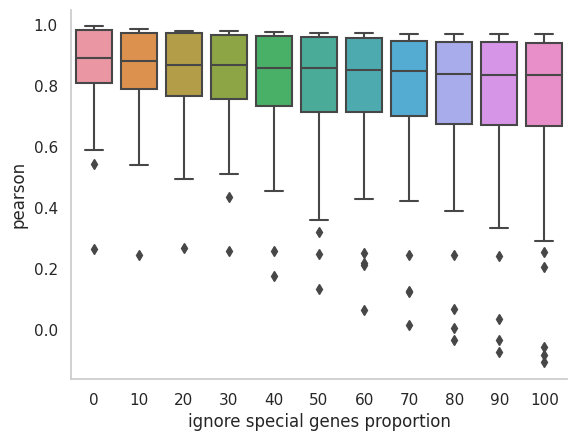

In [11]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x='ignore proportion', y='pearson', data=ignore_preds_info
)

sns.despine()
plt.grid(False)

plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

plt.show()

Text(0, 0.5, 'pearson')

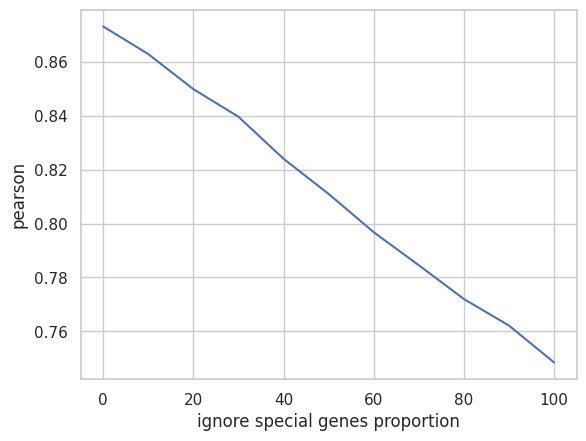

In [12]:
_group_by = ignore_preds_info.groupby('ignore proportion').mean()
x, y = _group_by.index, _group_by.values.flatten()
plt.plot(x, y)
plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

In [13]:
ignore_preds_info = []
for i in range(0, 101, 10):
    pearsons = evaluate(
        '/lmh_data/data/sclab/sclab/eval_dataset.npy',
        '/lmh_data/data/sclab/sclab/tmp/SLC1A3/model_epoch_9.pth', 'SLC1A3', list(genes.index)[max(i-10, 0):i])
    _df = pd.DataFrame({'pearson': pearsons, 'ignore proportion': i})
    ignore_preds_info.append(_df)

ignore_preds_info = pd.concat(ignore_preds_info, axis=0, ignore_index=True)

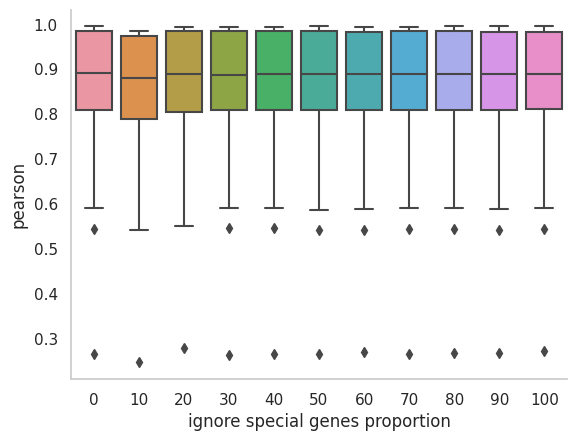

In [14]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x='ignore proportion', y='pearson', data=ignore_preds_info
)

sns.despine()
plt.grid(False)

plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

plt.show()

Text(0, 0.5, 'pearson')

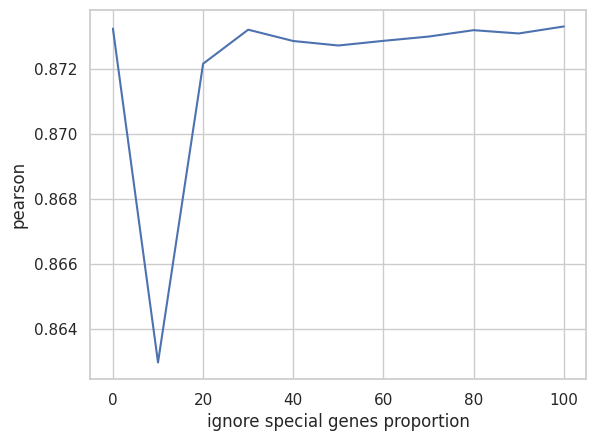

In [15]:
_group_by = ignore_preds_info.groupby('ignore proportion').mean()
x, y = _group_by.index, _group_by.values.flatten()
plt.plot(x, y)
plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

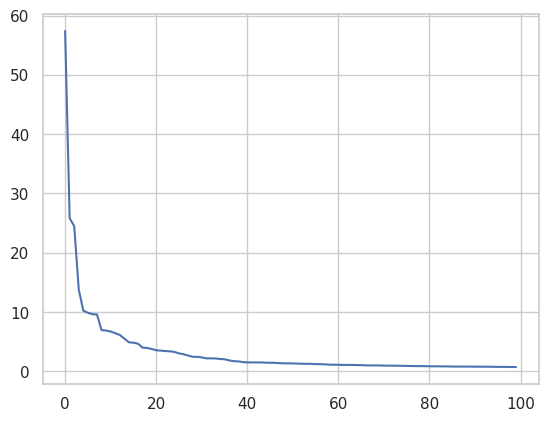

In [16]:
y = genes.value.values.flatten()

x = [i for i in range(len(y))]
plt.plot(x, y)